In [99]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.fft import fft
import os
from scipy.fftpack import fft
from scipy.io import loadmat
from sklearn.decomposition import PCA


In [100]:
# Load the EEG data
in_dir = r'D:\Imputed_file'    # EEG data folder
miscDir = r'C:\Users\napat\Documents\GitHub\BCC_2024\Code\Misc'     # Misc folder (if necessary)

fs = 125
sec_start = 15
epochLenSec = 4 * 60   
epoch_len_samp = fs * epochLenSec

# Load the tempos
tempo_data = sio.loadmat(os.path.join(miscDir, 'tempoHz.mat'))
tempoHz = tempo_data['tempoHz'].flatten()


In [101]:
# Function to apply median DC correction
def median_dc_correct_all_trials(data):
    return data - np.median(data, axis=1, keepdims=True)

def plot_combined_frequency_domain(data, fs, tempoHz, song_idx=1, num_channels_first_plot=10):
    # Step 1: Reduce the number of channels for the first plot only
    selected_channels = data[::max(1, data.shape[0] // num_channels_first_plot), :, :]  # Select fewer channels for first plot

    T = data.shape[1]
    freq_axis = np.fft.fftfreq(T, d=1/fs)[:T // 2]

    # Compute FFT for the selected channels for the first plot
    mean_channels = np.mean(selected_channels, axis=2)  # Mean across trials
    fft_data = np.abs(fft(mean_channels, axis=1))[:, :T // 2]

    # Filter to 0-15 Hz range
    valid_freqs = freq_axis <= 15
    freq_axis = freq_axis[valid_freqs]
    fft_data = fft_data[:, valid_freqs]

    # Create the combined figure
    fig, axs = plt.subplots(2, 1, figsize=(20, 15))  # Two plots stacked vertically

    # First plot (Mean Frequency-Domain Signal using fewer channels)
    for ch in range(fft_data.shape[0]):
        axs[0].bar(freq_axis, fft_data[ch, :], width=0.2, color='black', zorder=1)

    # Add vertical lines for the harmonics (only within the 0-15 Hz range)
    if tempoHz / 4 <= 15:
        axs[0].axvline(x=tempoHz / 4, color='blue', linestyle='--', linewidth=6, zorder=0)
    if tempoHz / 2 <= 15:
        axs[0].axvline(x=tempoHz / 2, color='orange', linestyle='--', linewidth=6, zorder=0)
    if tempoHz <= 15:
        axs[0].axvline(x=tempoHz, color='green', linestyle='--', linewidth=6, zorder=0)
    if tempoHz * 2 <= 15:
        axs[0].axvline(x=tempoHz * 2, color='red', linestyle='--', linewidth=6, zorder=0)
    if tempoHz * 4 <= 15:
        axs[0].axvline(x=tempoHz * 4, color='purple', linestyle='--', linewidth=6, zorder=0)
    if tempoHz * 8 <= 15:
        axs[0].axvline(x=tempoHz * 8, color='brown', linestyle='--', linewidth=6, zorder=0)

    # Customize appearance of the first plot
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title(f'Song {song_idx - 20}', fontsize=60)
    axs[0].set_ylabel('ME', fontsize=48)

    # Second plot (PC1 Frequency-Domain Signal using all channels)
    pca = PCA(n_components=1)
    pca_data = pca.fit_transform(data.reshape(data.shape[0], -1).T).T[0]  # Use all channels for PCA (PC1)
    fft_pca = np.abs(fft(pca_data))[:T // 2]
    fft_pca = fft_pca[valid_freqs]

    axs[1].bar(freq_axis, fft_pca, width=0.2, color='black', zorder=1)

    # Add vertical lines for the harmonics in the second plot (only within the 0-15 Hz range)
    if tempoHz / 4 <= 15:
        axs[1].axvline(x=tempoHz / 4, color='blue', linestyle='--', linewidth=6, zorder=0)
    if tempoHz / 2 <= 15:
        axs[1].axvline(x=tempoHz / 2, color='orange', linestyle='--', linewidth=6, zorder=0)
    if tempoHz <= 15:
        axs[1].axvline(x=tempoHz, color='green', linestyle='--', linewidth=6, zorder=0)
    if tempoHz * 2 <= 15:
        axs[1].axvline(x=tempoHz * 2, color='red', linestyle='--', linewidth=6, zorder=0)
    if tempoHz * 4 <= 15:
        axs[1].axvline(x=tempoHz * 4, color='purple', linestyle='--', linewidth=6, zorder=0)
    if tempoHz * 8 <= 15:
        axs[1].axvline(x=tempoHz * 8, color='brown', linestyle='--', linewidth=6, zorder=0)

    # Customize appearance of the second plot
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)
    axs[1].set_xticks([0, 5, 10])
    axs[1].tick_params(axis='x', length=10, width=2)
    axs[1].set_xticklabels([0, 5, 10], fontsize=40)
    axs[1].set_yticks([])
    axs[1].set_ylabel('PC1', fontsize=48)

    plt.show()
    
    # Save the figure
    fig_filename = f'EEG_ME_PC1_Songs_{song_idx}.png'
    fig.savefig(fig_filename, dpi=300)
    print(f"EEG for song {song_idx} saved as '{fig_filename}'.")


Loading song21_Imputed.mat...


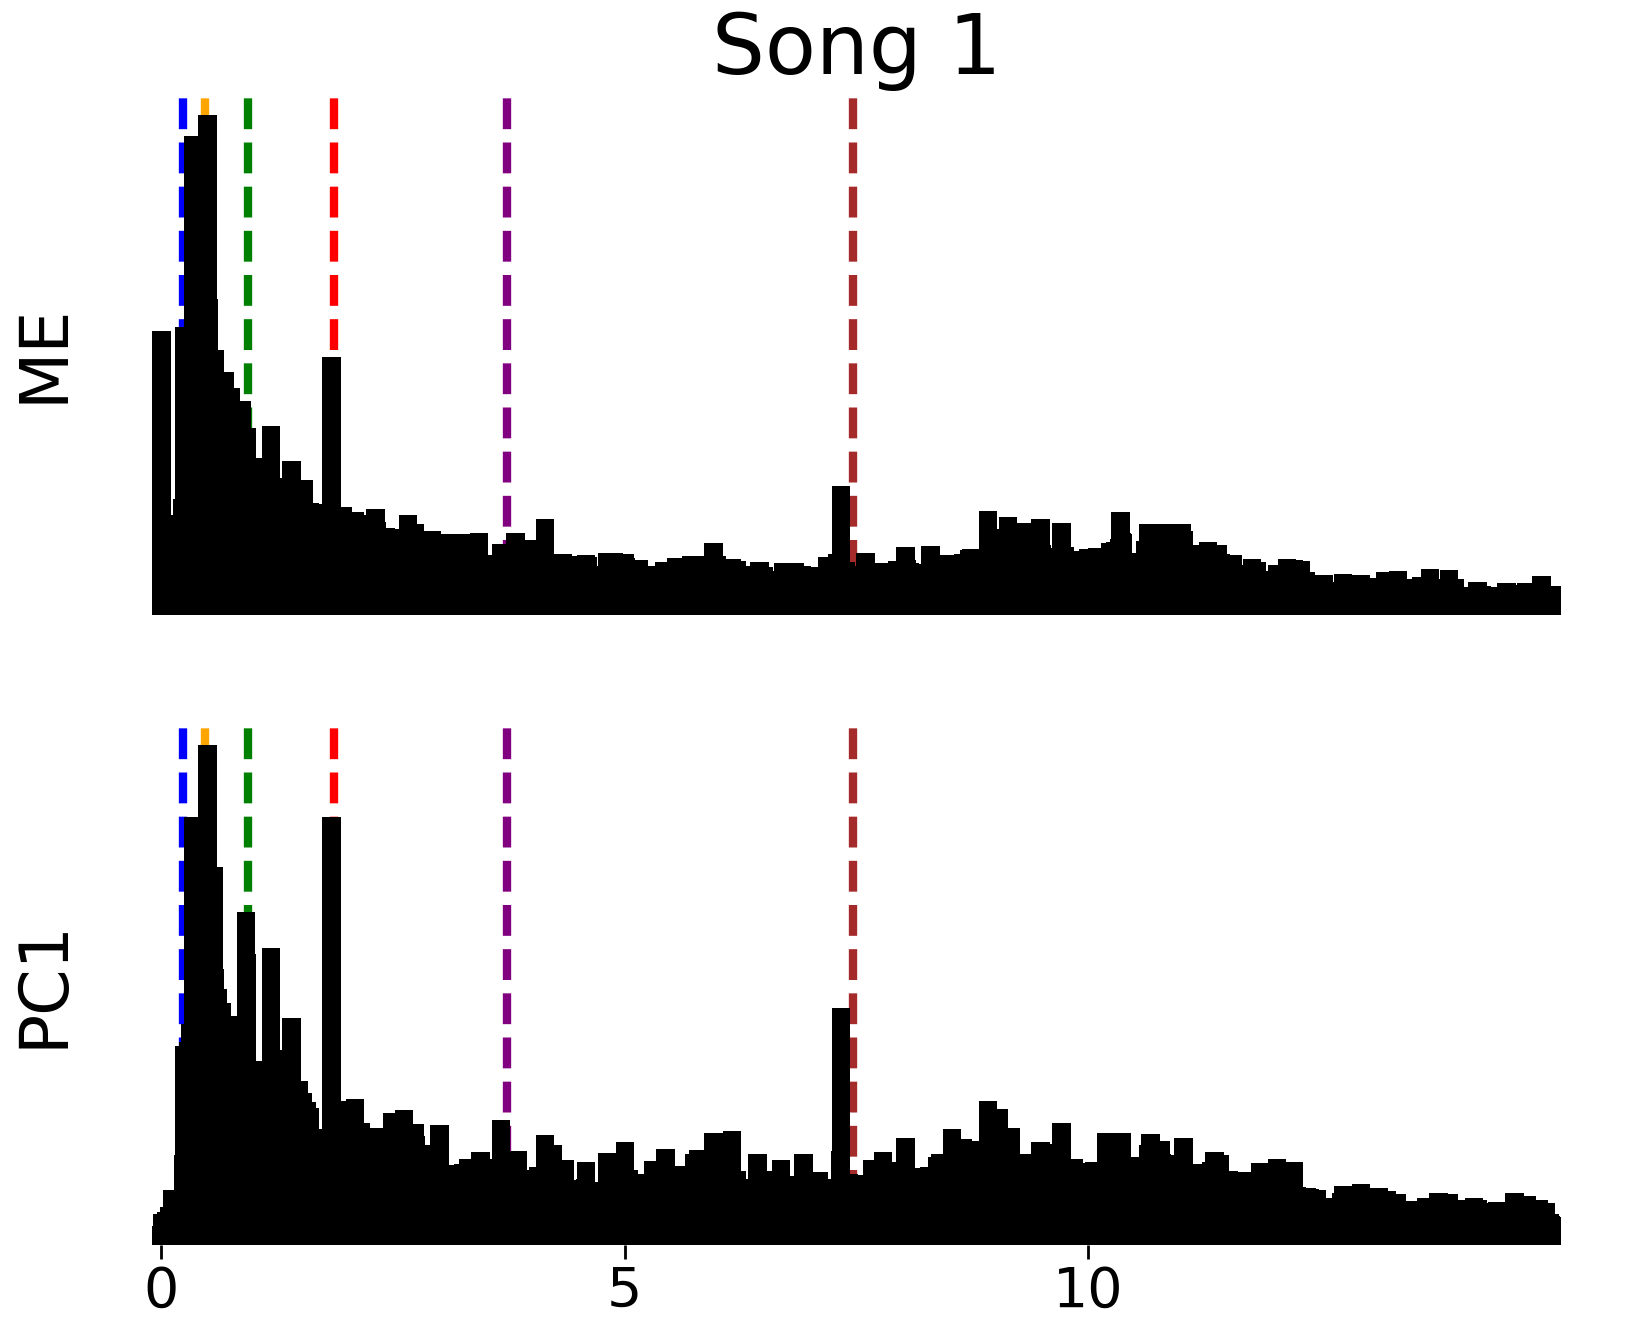

EEG for song 21 saved as 'EEG_ME_PC1_Songs_21.png'.
Loading song22_Imputed.mat...


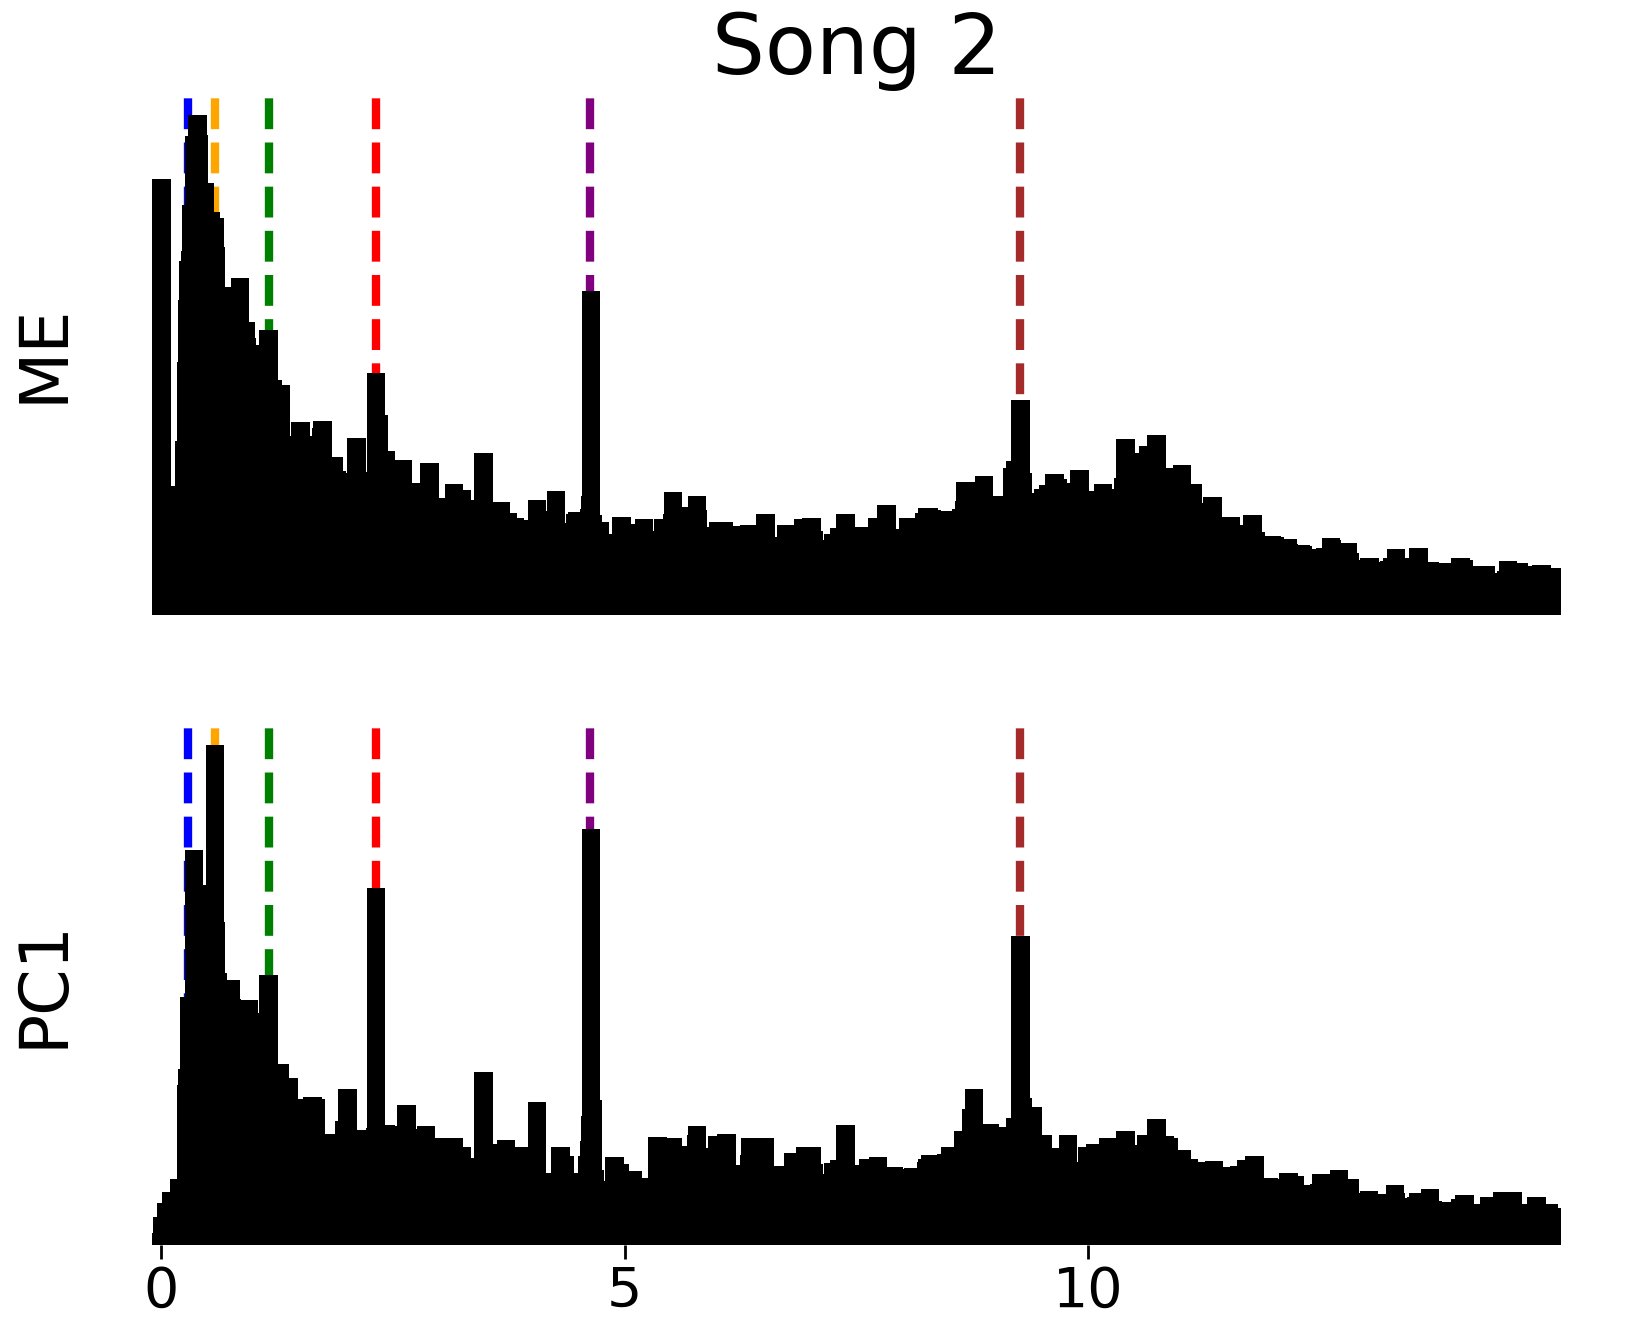

EEG for song 22 saved as 'EEG_ME_PC1_Songs_22.png'.
Loading song23_Imputed.mat...


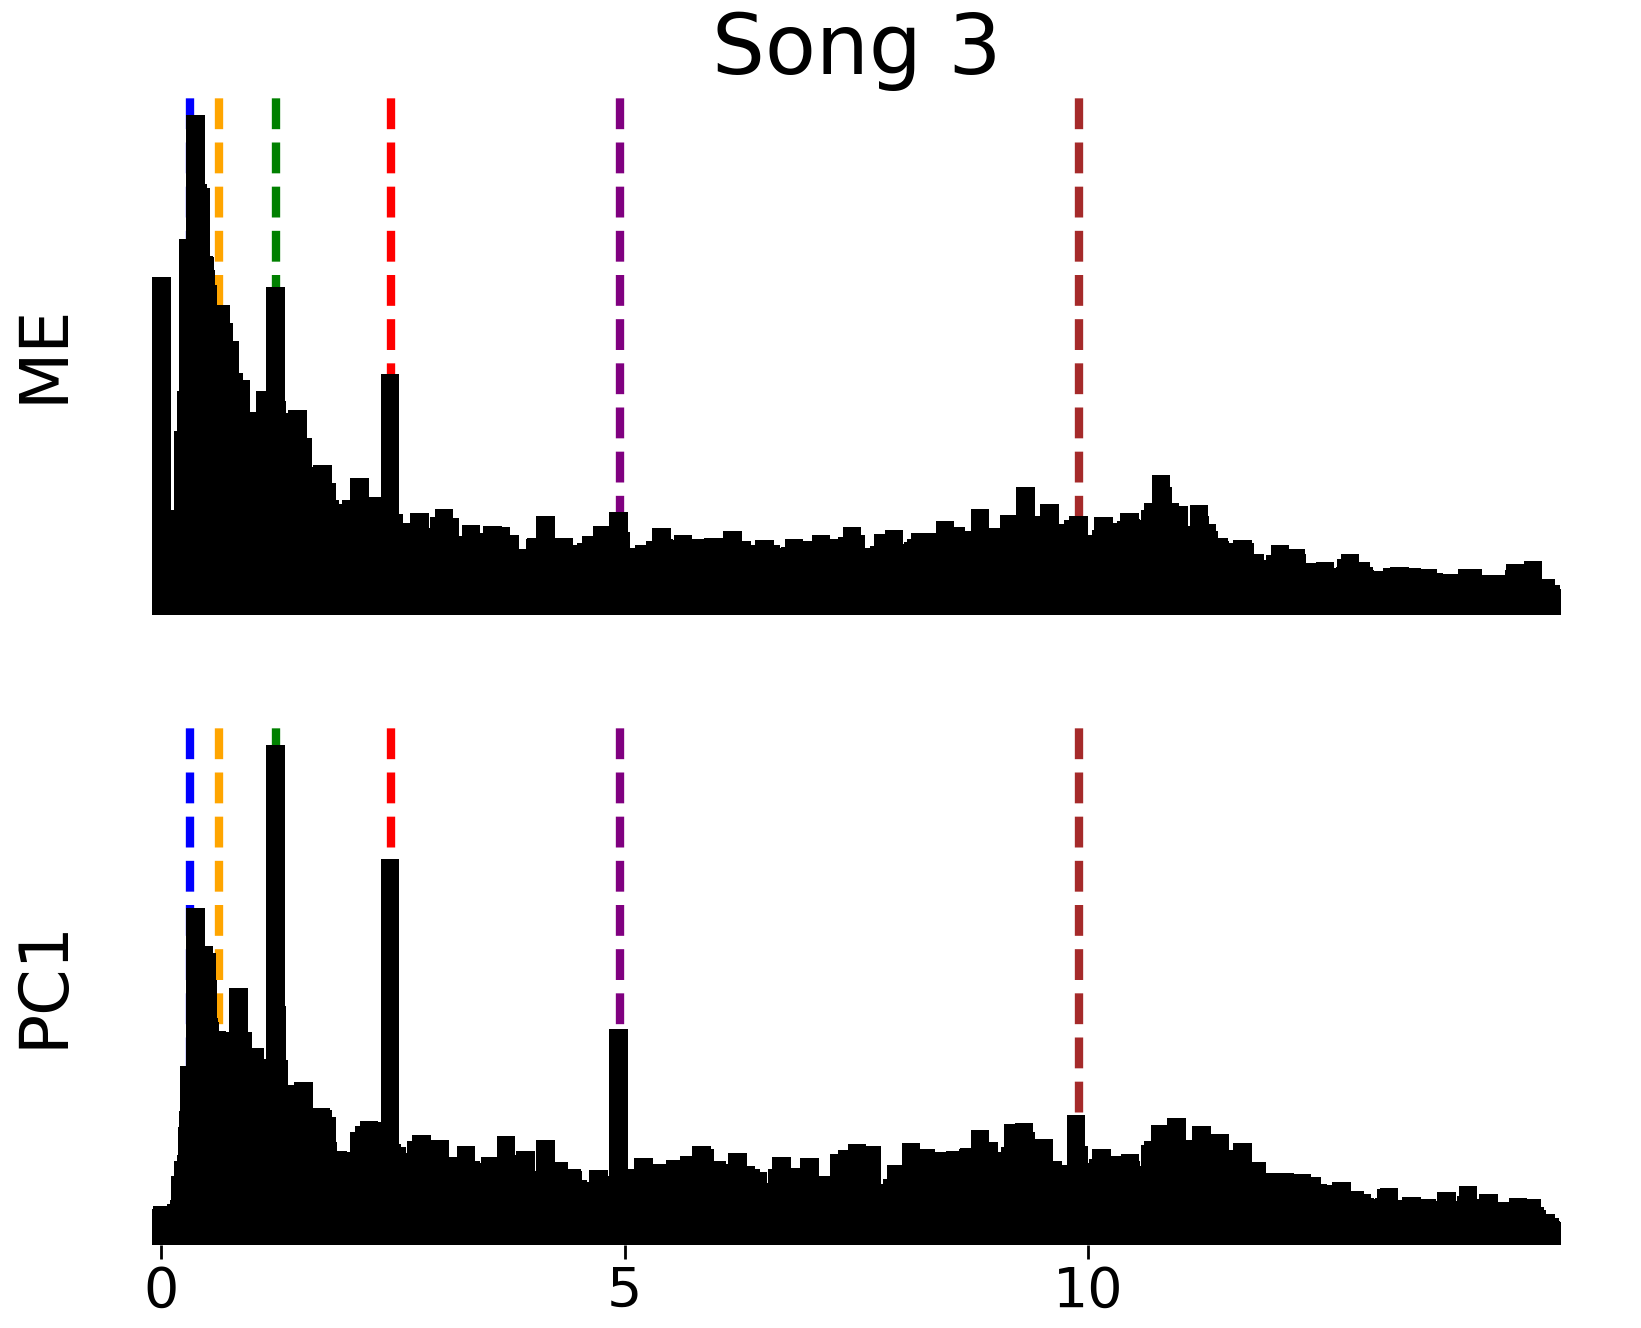

EEG for song 23 saved as 'EEG_ME_PC1_Songs_23.png'.
Loading song24_Imputed.mat...


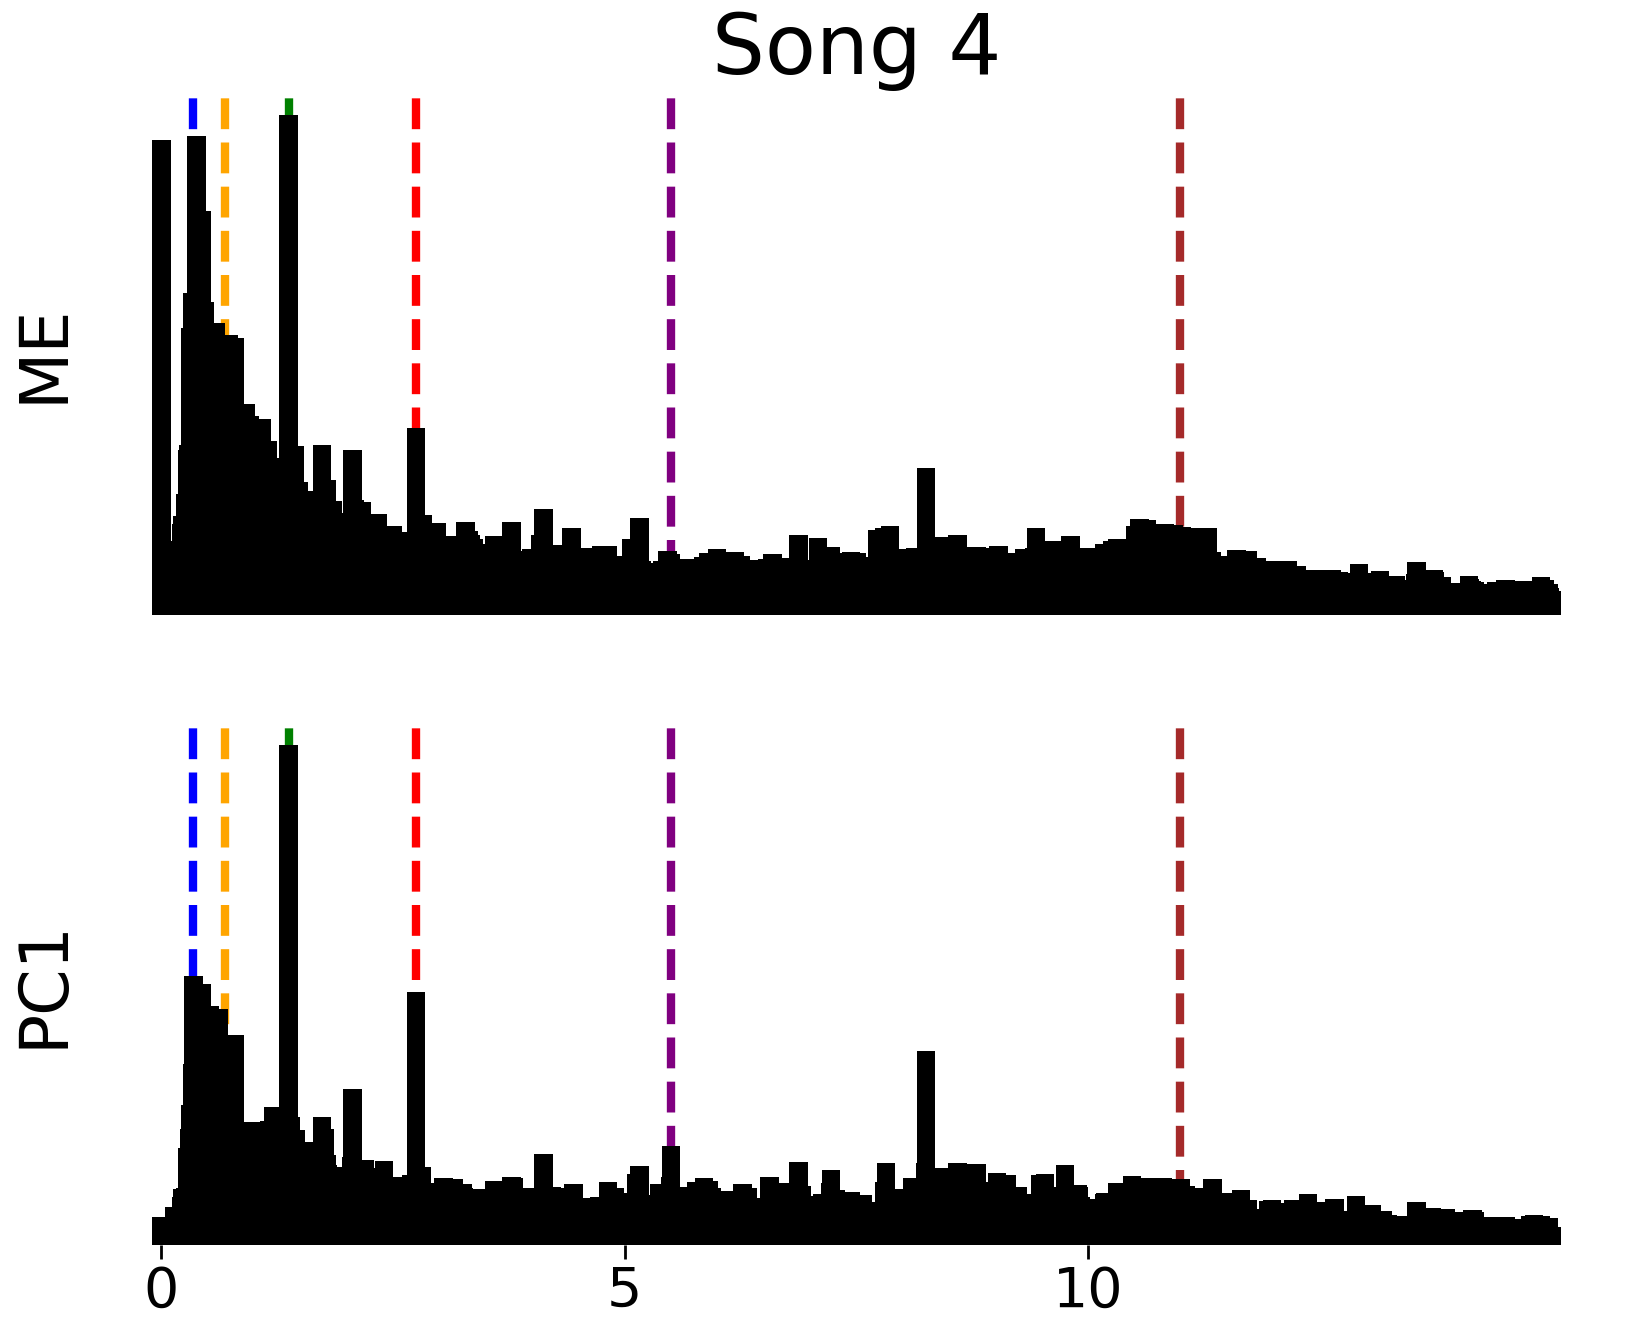

EEG for song 24 saved as 'EEG_ME_PC1_Songs_24.png'.
Loading song25_Imputed.mat...


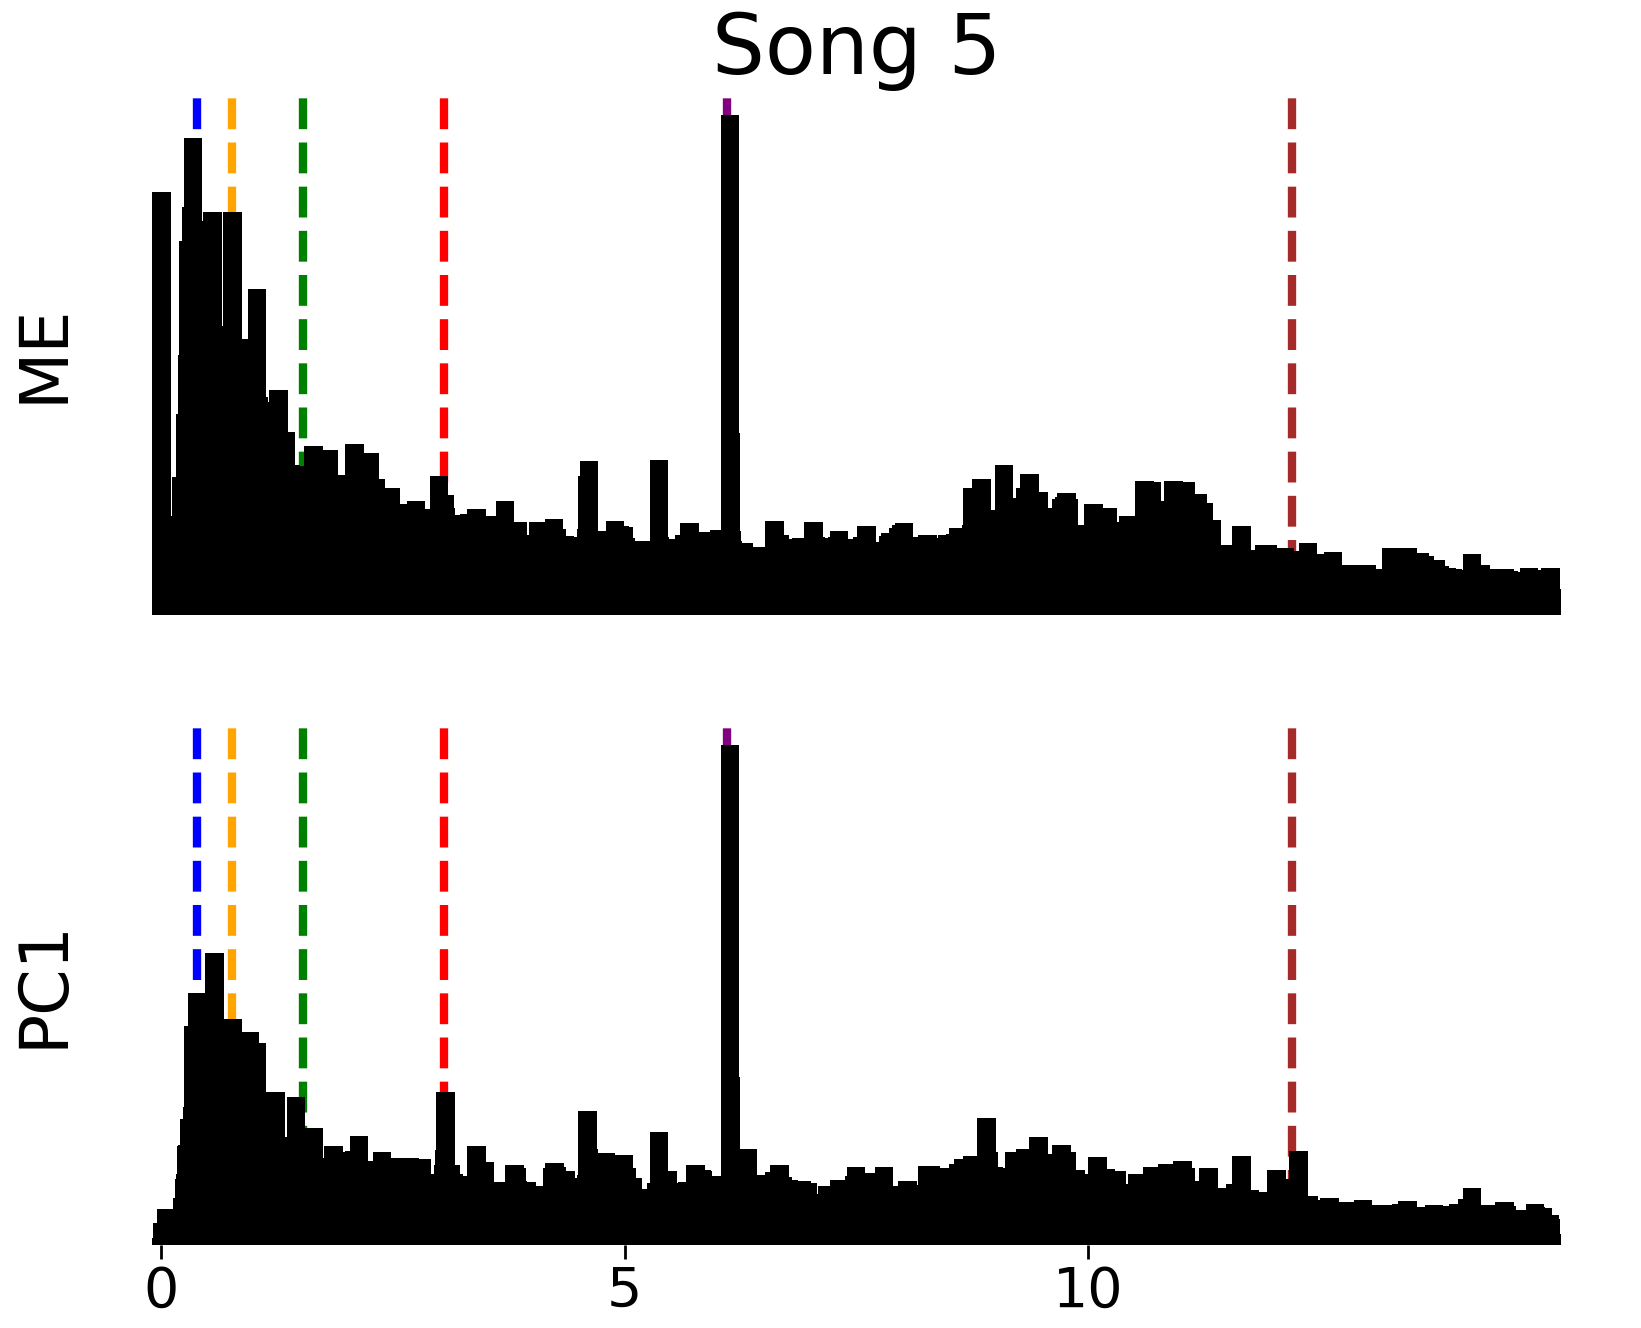

EEG for song 25 saved as 'EEG_ME_PC1_Songs_25.png'.
Loading song26_Imputed.mat...


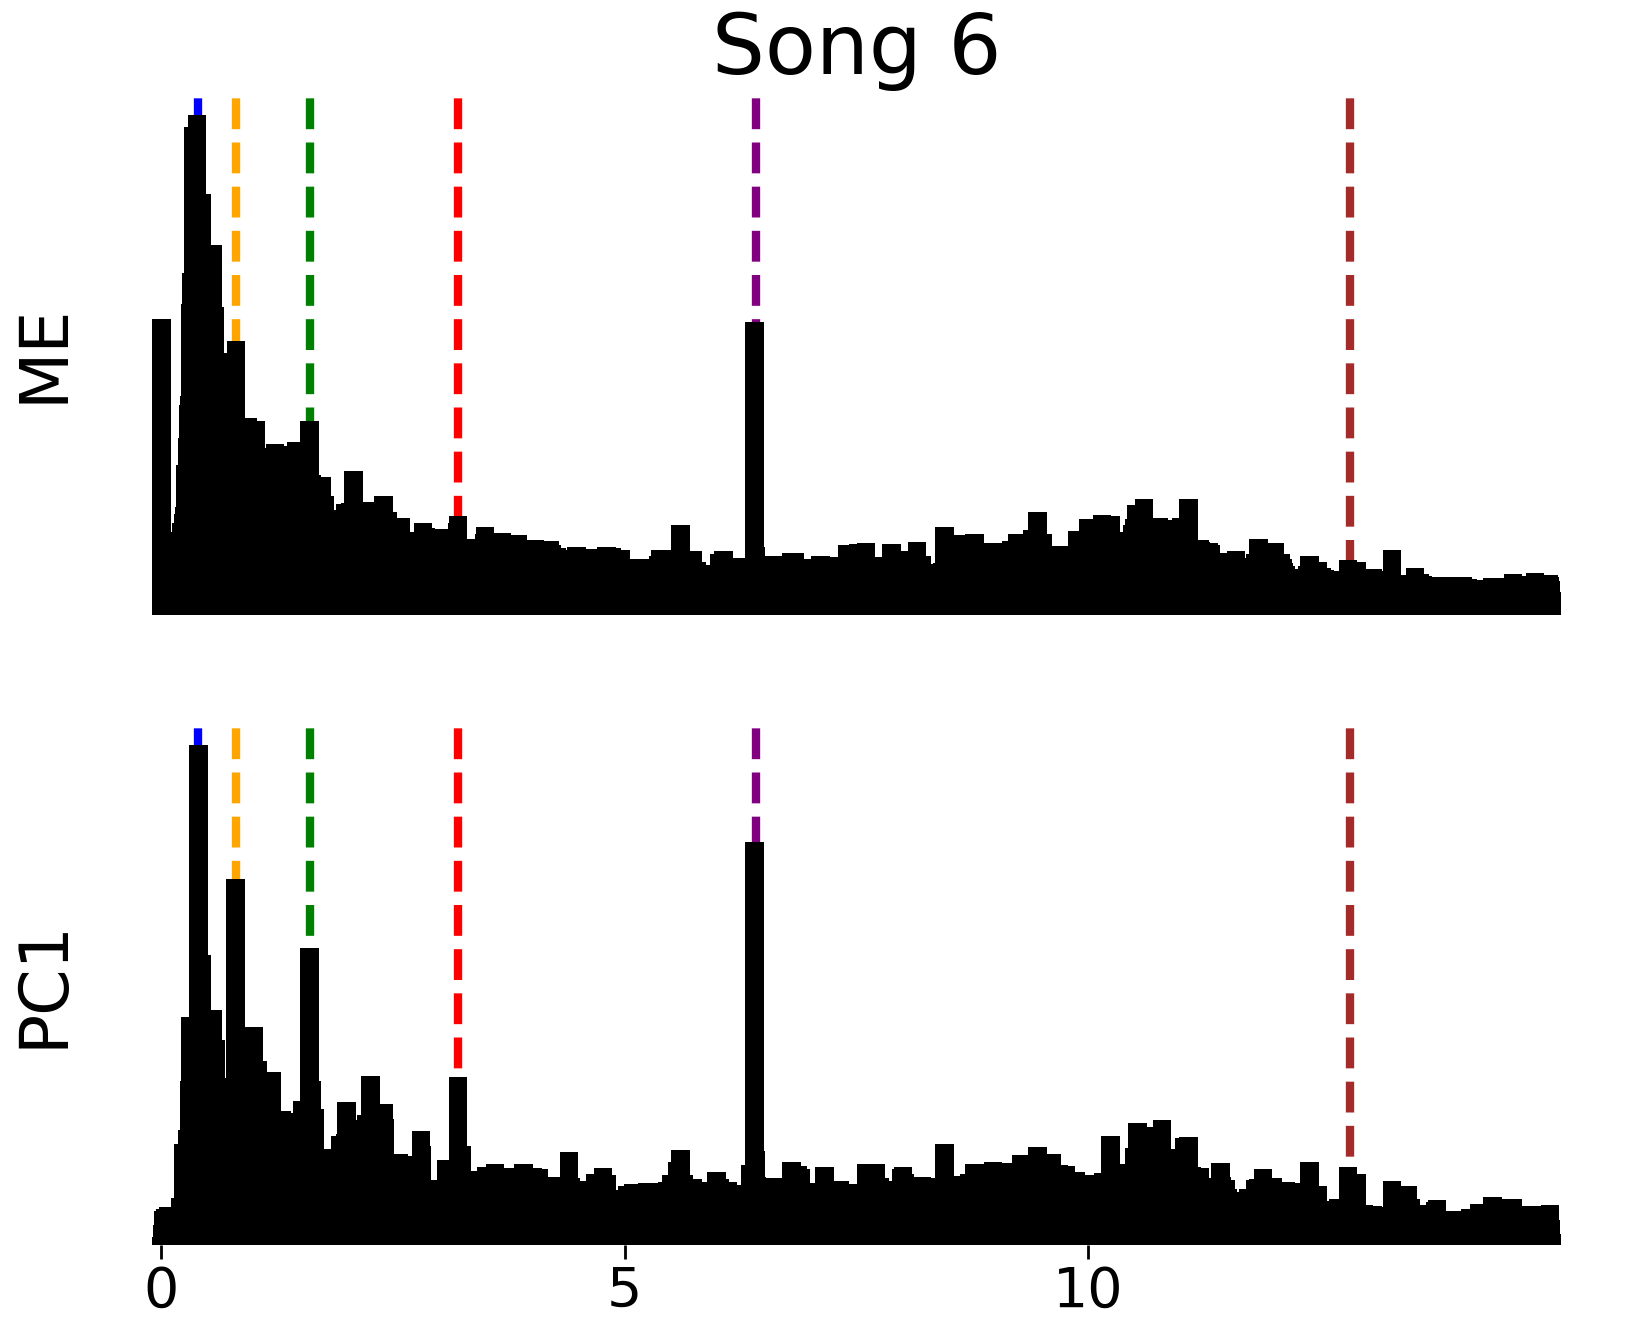

EEG for song 26 saved as 'EEG_ME_PC1_Songs_26.png'.
Loading song27_Imputed.mat...


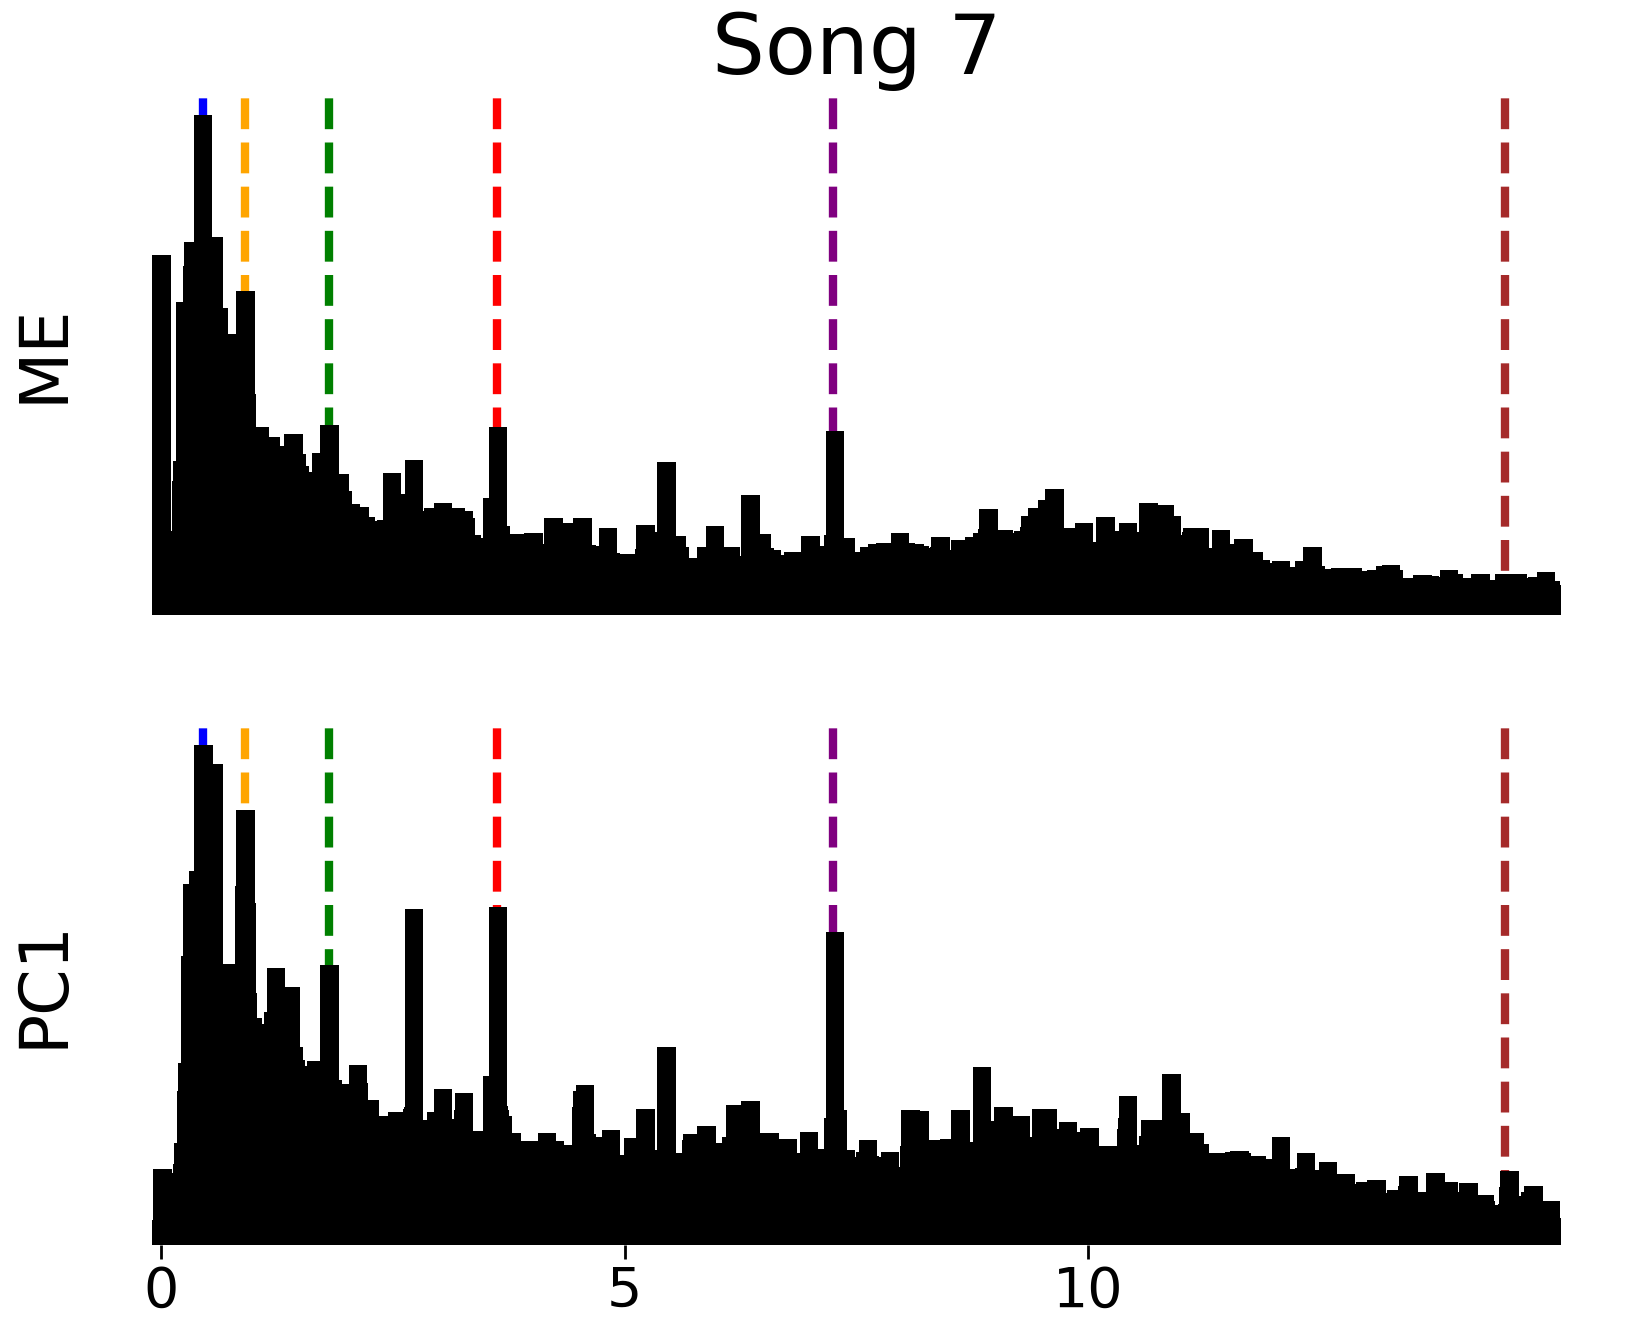

EEG for song 27 saved as 'EEG_ME_PC1_Songs_27.png'.
Loading song28_Imputed.mat...


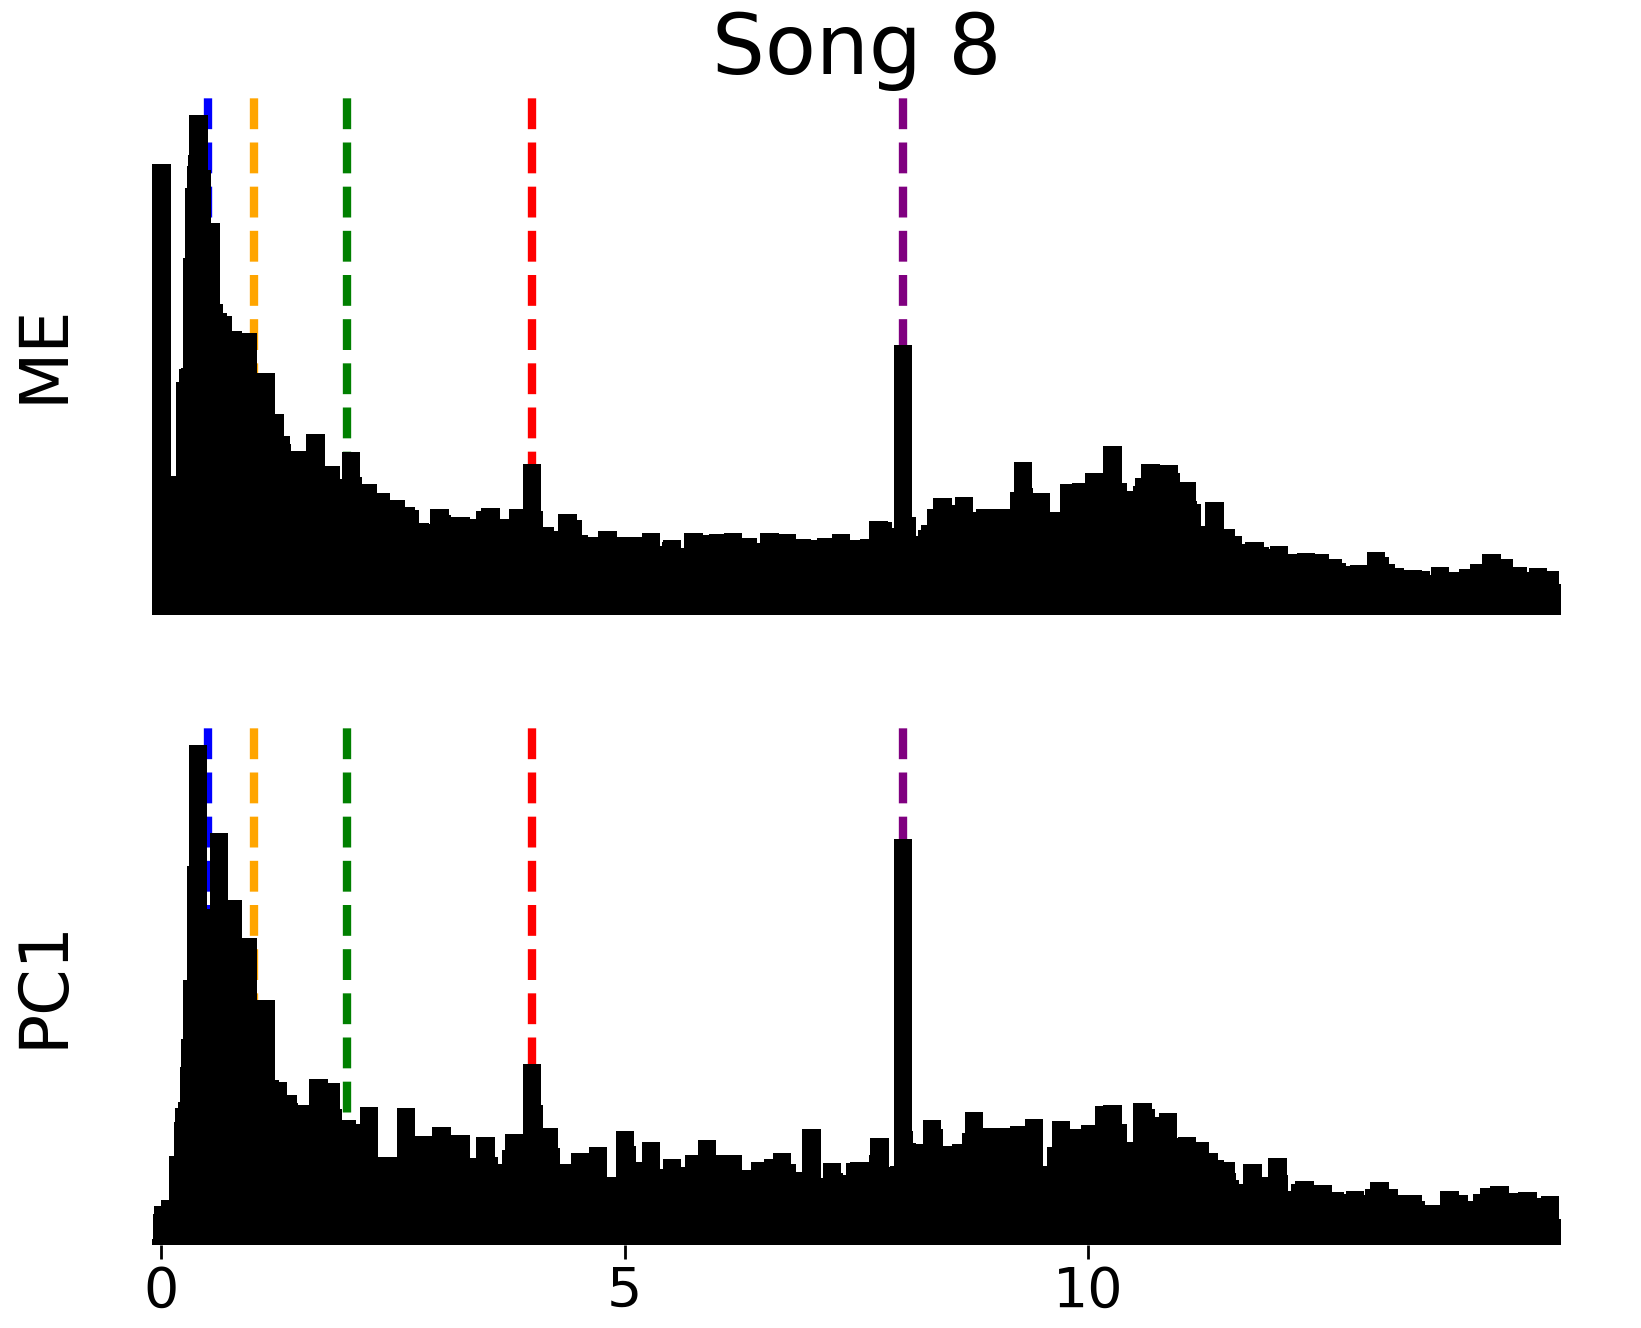

EEG for song 28 saved as 'EEG_ME_PC1_Songs_28.png'.
Loading song29_Imputed.mat...


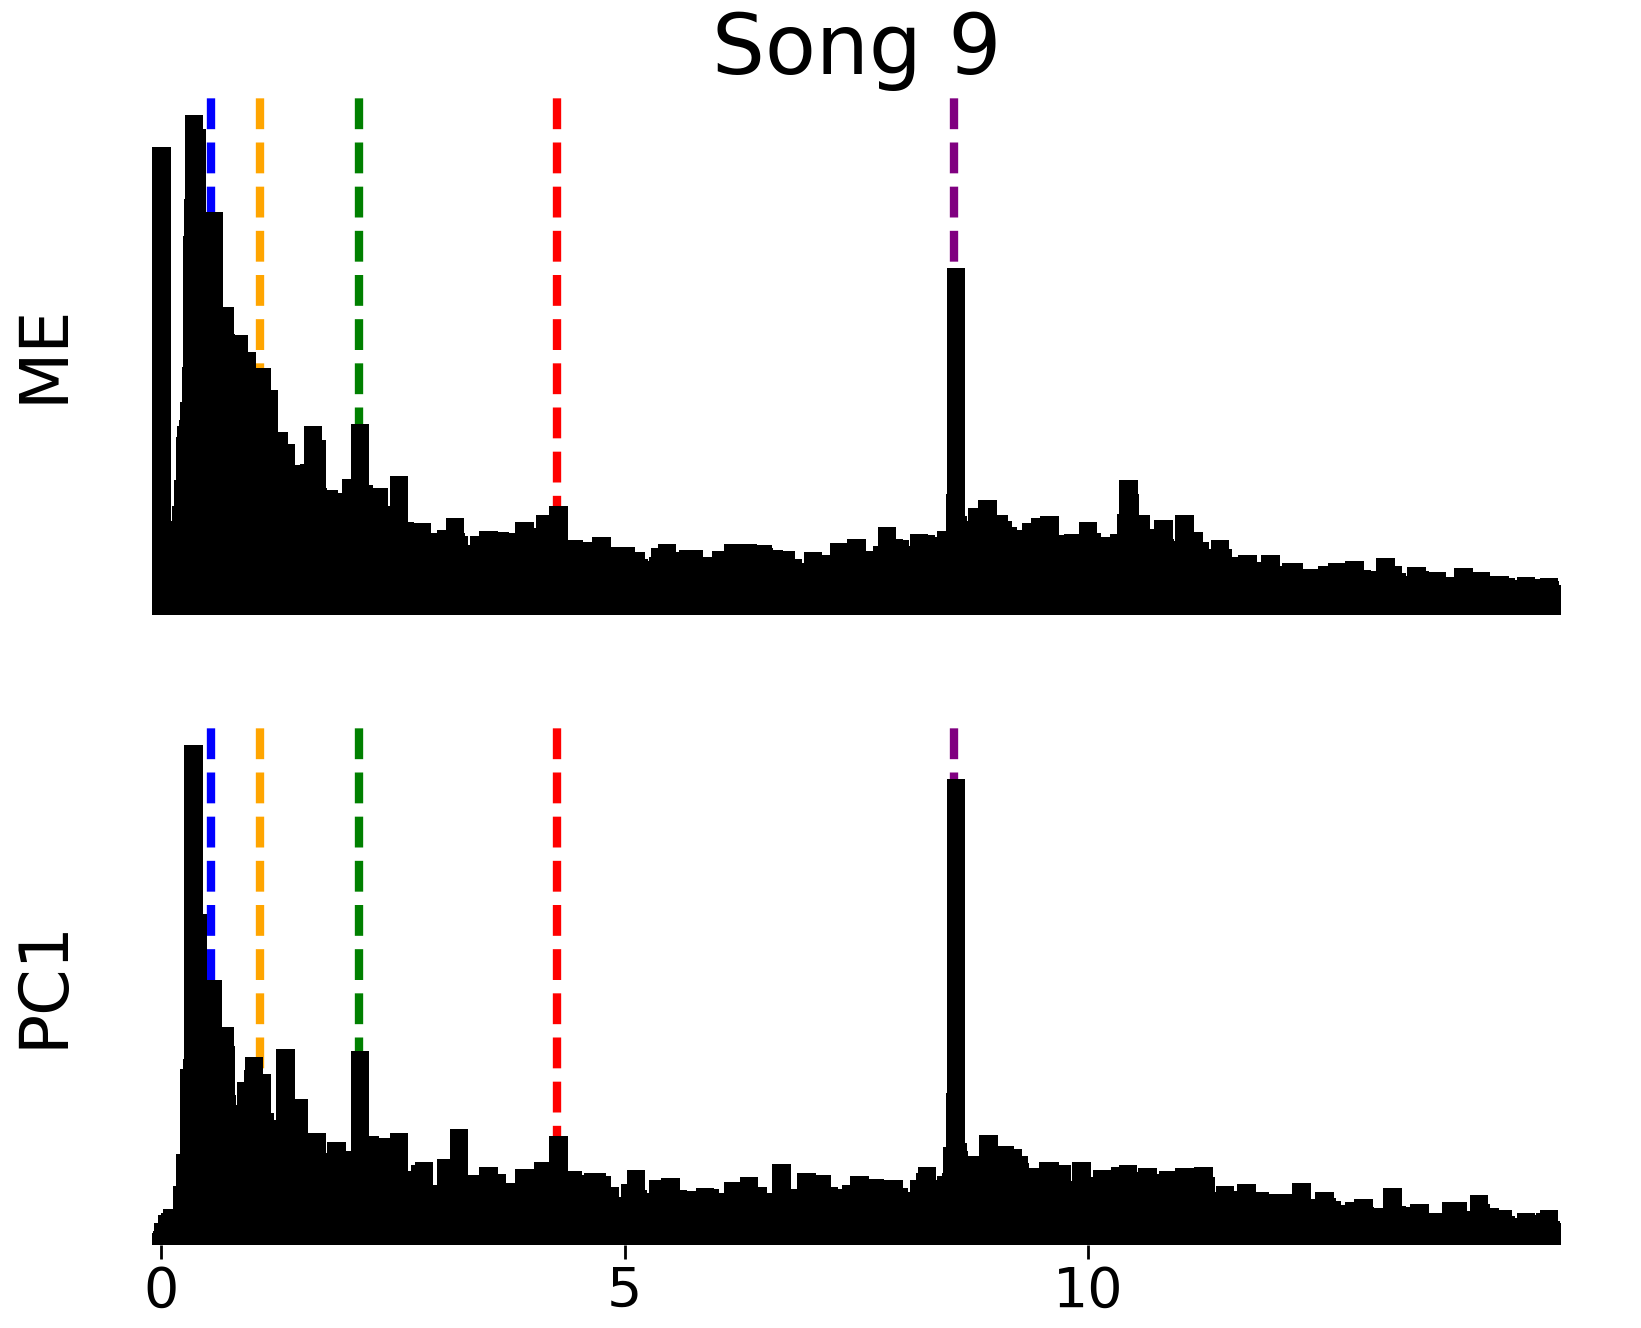

EEG for song 29 saved as 'EEG_ME_PC1_Songs_29.png'.
Loading song30_Imputed.mat...


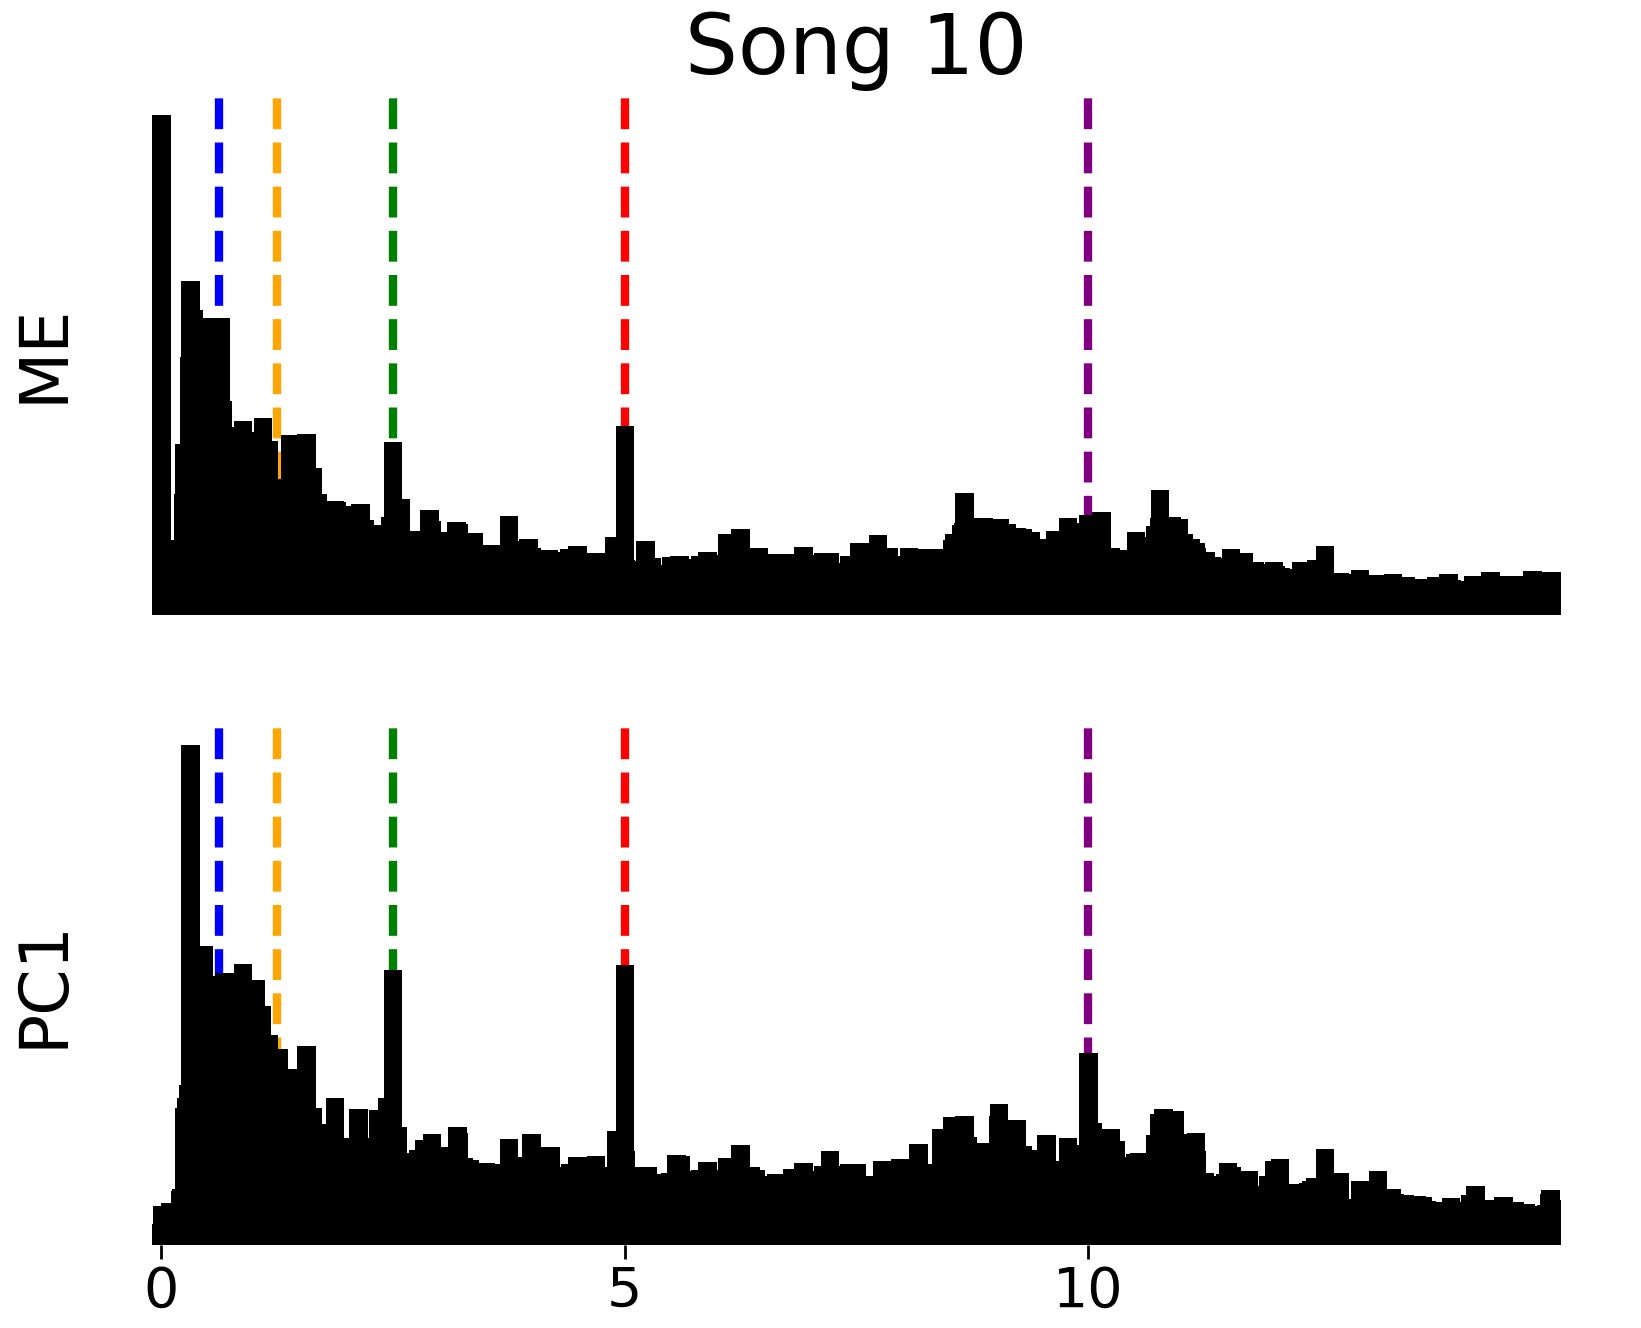

EEG for song 30 saved as 'EEG_ME_PC1_Songs_30.png'.


In [103]:
for i in range(1,11):
    # Initialize list to store trial mean data
    trialMeanData = []

    currFn = f'song{i+20}_Imputed.mat'
    print(f'Loading {currFn}...')
    data = sio.loadmat(os.path.join(in_dir, currFn))
    tempX_0 = data[f'data{i+20}']

    # Assuming a custom function medianDCCorrectAllTrialsInStruct exists
    tempX_dc = median_dc_correct_all_trials(tempX_0)
    tempX_epoch = tempX_dc[:, sec_start * fs:(sec_start * fs + epoch_len_samp), :]
    plot_combined_frequency_domain(tempX_epoch, fs,tempoHz[i-1], song_idx=20+i)

asdasdas

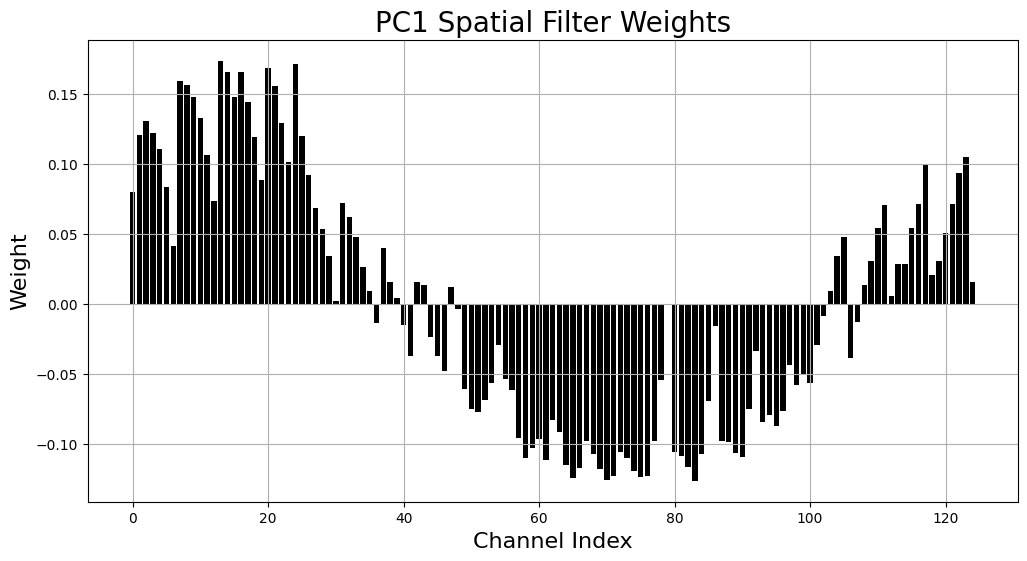

In [104]:
def plot_pc1_spatial_filter(data, fs):
    # Reshape data for PCA: (n_channels, n_times, n_trials) to (n_channels, n_times * n_trials)
    reshaped_data = data.reshape(data.shape[0], -1)
    
    # Apply PCA
    pca = PCA(n_components=1)
    pca.fit(reshaped_data.T)
    
    # Extract the PC1 weights (first principal component)
    pc1_weights = pca.components_[0]
    
    # Plot the PC1 spatial filter weights
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(pc1_weights)), pc1_weights, color='black')
    plt.title('PC1 Spatial Filter Weights', fontsize=20)
    plt.xlabel('Channel Index', fontsize=16)
    plt.ylabel('Weight', fontsize=16)
    plt.grid(True)
    plt.show()

# Example usage:
plot_pc1_spatial_filter(tempX_epoch, fs)